<a href="https://colab.research.google.com/github/Lojain12/Flight_Price/blob/main/Copy_of_FlightPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight price prediction**
### Our goal is to build supervised Natural Language Processing (NLP) machine learning models to predict the price of a flight.

### **Import Libaries**

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

### **Load the data**

In [4]:
flight = pd.read_csv("Flight_price.csv")
flight.head()

,number,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Take a 100,000 sample

In [5]:
flight = flight.sample(n=1000, random_state=42)

### **View data**

In [6]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 27131 to 75274
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            1000 non-null   int64  
 1   airline           1000 non-null   object 
 2   flight            1000 non-null   object 
 3   source_city       1000 non-null   object 
 4   departure_time    1000 non-null   object 
 5   stops             1000 non-null   object 
 6   arrival_time      1000 non-null   object 
 7   destination_city  1000 non-null   object 
 8   class             1000 non-null   object 
 9   duration          1000 non-null   float64
 10  lead_reservation  1000 non-null   int64  
 11  price             1000 non-null   int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 101.6+ KB


In [7]:
flight.describe()

,number,duration,lead_reservation,price
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,144905.771000,12.169290,25.882000,20020.685000
std,87018.045615,7.172312,13.599302,22496.083452
min,49.000000,1.080000,1.000000,1105.000000
25%,69877.000000,6.670000,14.000000,4823.750000
50%,143671.000000,11.250000,25.000000,7021.000000
75%,218396.750000,16.020000,38.000000,41269.000000
max,300089.000000,36.830000,49.000000,98839.000000


In [8]:
flight.shape

(1000, 12)

**Check number of null values**

In [9]:
flight.isnull().sum()

number              0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
lead_reservation    0
price               0
dtype: int64

Check duplicates 

In [10]:
flight.duplicated().sum()

0

number of unique data for each feature

In [11]:
flight.nunique()

number              1000
airline                6
flight               449
source_city            6
departure_time         6
stops                  3
arrival_time           6
destination_city       6
class                  2
duration             290
lead_reservation      49
price                662
dtype: int64

As we understand from the result above, the "number" column is an index since its unique values are just like the size of our dataset, which is 300153.
So, it will be dropped from our dataset.

In [12]:
flight.drop(["number"], axis=1, inplace=True)

In [13]:
flight.drop(["flight"], axis=1, inplace=True)

In [14]:
flight.shape

(1000, 10)

convert price from int to float

In [15]:
flight['price'] = flight['price'].astype(float)

**Draw histogram to view the numeric values distribution**

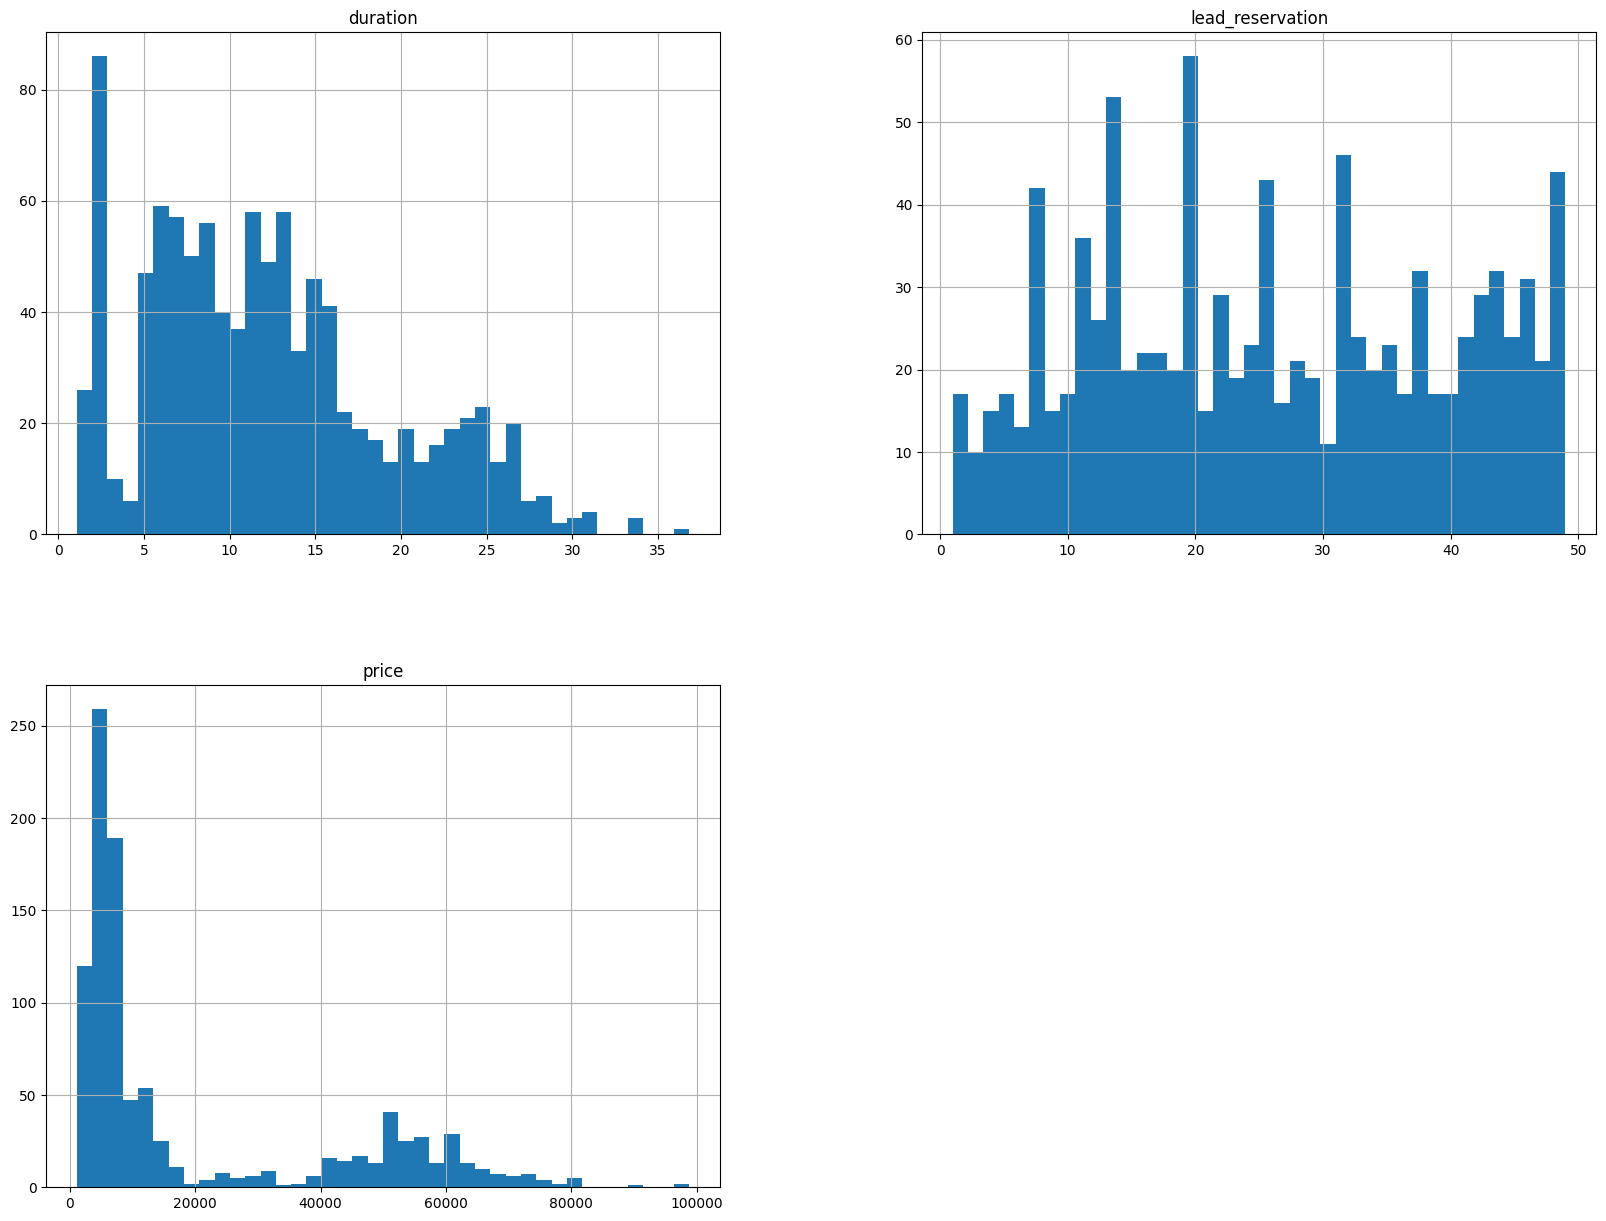

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
flight.hist(bins=40, figsize=(20,15))
plt.show()

**Detect and Remove outliers** 

<Axes: xlabel='lead_reservation'>

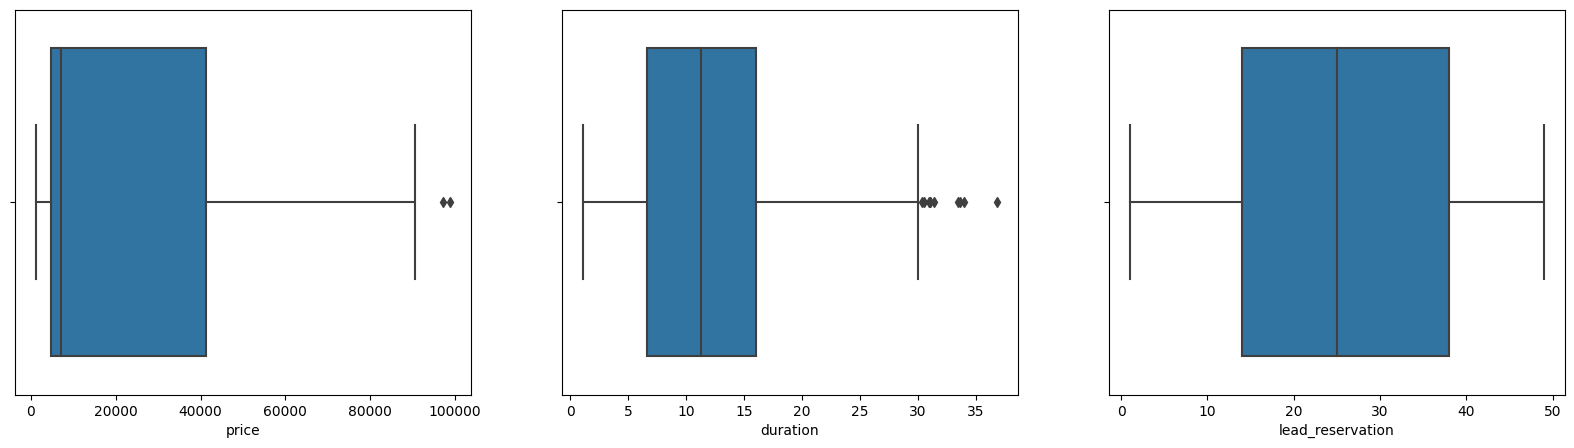

In [17]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

In [18]:
Q1 = flight.quantile(0.25)
Q3 = flight.quantile(0.75)
IQR = Q3 - Q1
flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]

<ipython-input-18-63ea7a9fe649>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]


<Axes: xlabel='lead_reservation'>

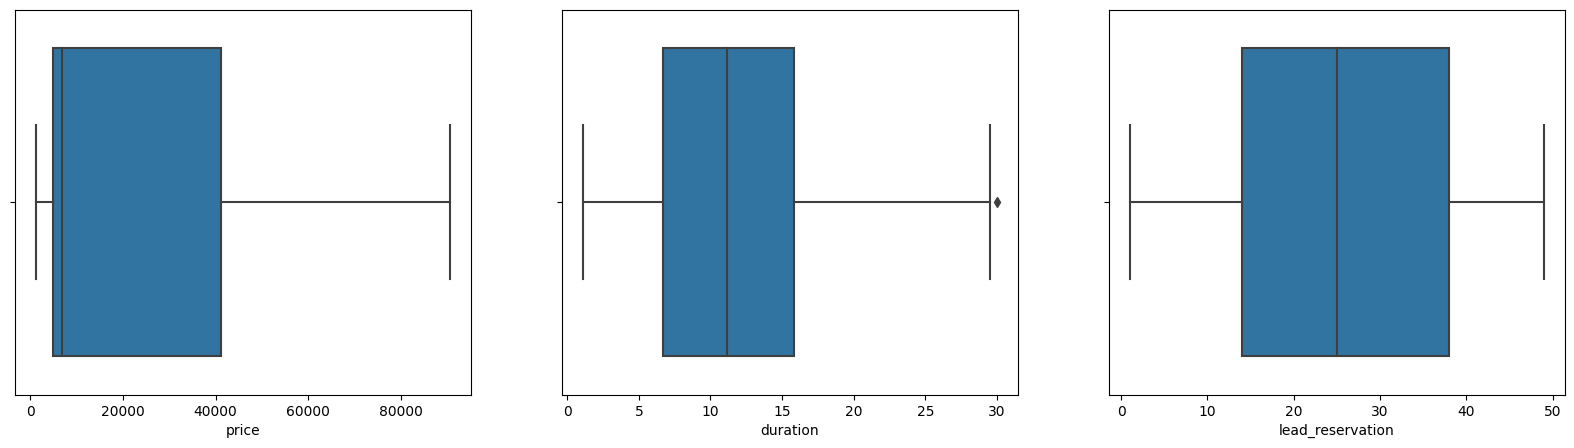

In [19]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

we will use the StratifiedShuffleSplit to split the data keeping the same distribution of class category.

In [20]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 27131 to 75274
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           988 non-null    object 
 1   source_city       988 non-null    object 
 2   departure_time    988 non-null    object 
 3   stops             988 non-null    object 
 4   arrival_time      988 non-null    object 
 5   destination_city  988 non-null    object 
 6   class             988 non-null    object 
 7   duration          988 non-null    float64
 8   lead_reservation  988 non-null    int64  
 9   price             988 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 84.9+ KB


In [21]:
flight["class"].value_counts()

Economy     700
Business    288
Name: class, dtype: int64

In [22]:
from sklearn.preprocessing import OneHotEncoder
class1 = flight[["class"]]
cat_encoder = OneHotEncoder()
class_1hot = cat_encoder.fit_transform(class1)

In [23]:
from sklearn.preprocessing import OneHotEncoder
class1 = flight[["stops"]]
cat_encoder = OneHotEncoder()
class_1hot = cat_encoder.fit_transform(class1)

In [24]:
class_1hot.shape

(988, 3)

In [25]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 27131 to 75274
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           988 non-null    object 
 1   source_city       988 non-null    object 
 2   departure_time    988 non-null    object 
 3   stops             988 non-null    object 
 4   arrival_time      988 non-null    object 
 5   destination_city  988 non-null    object 
 6   class             988 non-null    object 
 7   duration          988 non-null    float64
 8   lead_reservation  988 non-null    int64  
 9   price             988 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 84.9+ KB


In [26]:
flight["class1"] = pd.cut(flight["class"], bins = [], labels = [0,1])
flight["class1"].hist()

ValueError: ignored

### **Get the size of taining set and test set**

In [ ]:
#using Scikit-Learn train_test_split()
train_set, test_set = train_test_split(flight, test_size=0.2, random_state=42)
print("size of training data",len(train_set))
print("size of testing data",len(test_set))

In [ ]:
#Split the dataset into training and testing sets using StratifiedShuffleSplit based on the Class column
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(flight, flight["class1"]):
    strat_train_set = flight.loc[train_index]
    strat_test_set = flight.loc[test_index]

In [ ]:
#strat_test_set["class1"].value_counts()/ len(strat_test_set)

In [ ]:
#strat_train_set["class1"].value_counts()/ len(strat_train_set)

In [ ]:
##flight["class1"].value_counts()/ len(data)

In [ ]:
##for set_ in (strat_train_set, strat_test_set):
  ##set_.drop("class1", axis=1, inplace=True)

In [ ]:
##strat_train_set.info()

**Correlation matrix**

In [ ]:
##flight = strat_train_set.copy()
corr_matrix= flight.corr()
corr_matrix["price"].sort_values(ascending=False)

In [ ]:
corr_matrix

In [ ]:
print(flight["stops"].isnull().sum())

In [ ]:
from pandas.plotting import scatter_matrix
attributes=["duration","class","lead_reservation","price"]
scatter_matrix(flight[attributes], figsize=(12,8))

In [ ]:
flight['stops'].value_counts()

### **Random Forest**

In [ ]:
flightX = train_set.drop("price", axis =1)
flightX = train_set["price"].copy()
X_train, X_test, y_train, y_test = train_test_split(flightX, flightX, test_size=0.2, random_state=42)